In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import scipy.sparse as sp_sparse
import scanpy as sc
from math import log
from statistics import median
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
import keras.losses

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Data Preparation

In [2]:
adata = sc.read_10x_mtx(
    '/home/ahmadazim/data/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

In [3]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 2700 cells and 32738 genes


In [4]:
# Filter out genes that are not expressed in any cells
geneSum = data.sum(axis=0)
x = geneSum.index[geneSum == 0].tolist()
data = data.drop(x, axis = 1)
data.shape

(2700, 16634)

In [5]:
# Normalizing data (using method from Rao, et al.)
cellSum  = data.sum(axis=1)
median_j = median(cellSum)
npData = np.asarray(data)
for j in range(2700):
    cellSum_j = cellSum[j]
    for i in range(16634):
        npData[j,i] = log( ( (npData[j,i])/(cellSum_j) * median_j ) + 1)

In [6]:
dataNorm = pd.DataFrame(npData)
dataNorm

,0,1,2,3,4,5,6,7,8,9,...,16624,16625,16626,16627,16628,16629,16630,16631,16632,16633
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.532536,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.522734,0.0,0.0,0.370248,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.332558,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.980213,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.175435,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.491513,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.266796,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.827533,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.145975,0.0,0.0,0.000000,0.0,1.145975,0.0,0.0,0.0


# Implementing Autoencoder model

### (Info from TF tutorial below, but model not actually implemented)
- Use 2 small ConvNets for the encoder and decoder networks (inference/recognition and generative models)
- *x* = observation and *z* = latent variable
- Encoder network defines the approximate posterior distribution *q(z|x)*
    - Use 2 convolutional layers followed by a fully-connected layer
- Decoder network defines the approximate conditional distribution *p(x|z)*
    - Use a fully-connected layer followed by three convolution transpose layers
- Reparameterization Trick...
    - Backpropagation cannot flow through random node
    - Approximate *z* using the decoder parameters and another parameter $\epsilon$ as follows: 
        - $z = \mu + \sigma \odot \epsilon$
        - where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively
    - Enables model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ while maintaining stochasticity through $\epsilon$

## Convolutional Variational AutoEncoder (keras tutorial, but 1 Dimensional)

### Going to try dividing matrix into small "images" 
(2700 x 16634) --> 225 (12 x 72)

In [195]:
VMR = dataNorm.std() / dataNorm.mean() 
lowestVMR = VMR.sort_values(ascending=False)[(225*72):]
fullData = np.asarray(dataNorm.drop(lowestVMR.index, axis= 1))
fullData.shape

(2700, 16200)

In [241]:
# "Chunking" the matrix 
reshapeData = np.array([[[0 for x in range(72)] for x in range(12)] for x in range(50625)], dtype = 'float32')
for i in range(0, 2700, 12):   # i refers to cells (12)
    print("Starting i =", (i/12)+1)
    for j in range(0, 16200, 72):   # j refers to genes (72)
        x = ( 225*(i/12) ) + ( (j/72)+1 )
        smallMat = fullData[ i:(i+12) , j:(j+72) ]
        reshapeData[int(x-1),:,:] = smallMat

reshapeData = reshapeData.reshape((reshapeData.shape[0], reshapeData.shape[1], reshapeData.shape[2], 1))
reshapeData.shape

Starting i = 1.0
Starting i = 2.0
Starting i = 3.0
Starting i = 4.0
Starting i = 5.0
Starting i = 6.0
Starting i = 7.0
Starting i = 8.0
Starting i = 9.0
Starting i = 10.0
Starting i = 11.0
Starting i = 12.0
Starting i = 13.0
Starting i = 14.0
Starting i = 15.0
Starting i = 16.0
Starting i = 17.0
Starting i = 18.0
Starting i = 19.0
Starting i = 20.0
Starting i = 21.0
Starting i = 22.0
Starting i = 23.0
Starting i = 24.0
Starting i = 25.0
Starting i = 26.0
Starting i = 27.0
Starting i = 28.0
Starting i = 29.0
Starting i = 30.0
Starting i = 31.0
Starting i = 32.0
Starting i = 33.0
Starting i = 34.0
Starting i = 35.0
Starting i = 36.0
Starting i = 37.0
Starting i = 38.0
Starting i = 39.0
Starting i = 40.0
Starting i = 41.0
Starting i = 42.0
Starting i = 43.0
Starting i = 44.0
Starting i = 45.0
Starting i = 46.0
Starting i = 47.0
Starting i = 48.0
Starting i = 49.0
Starting i = 50.0
Starting i = 51.0
Starting i = 52.0
Starting i = 53.0
Starting i = 54.0
Starting i = 55.0
Starting i = 56.0
S

(50625, 12, 72, 1)

In [20]:
# Create a sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [71]:
# Build the encoder
latent_dim = 32

encoder_inputs = keras.Input(shape=(12, 72, 1))
x = layers.Conv2D(filters= 32, kernel_size= 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(filters= 64, kernel_size= 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 12, 72, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 6, 36, 32)    320         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 3, 18, 64)    18496       conv2d_14[0][0]                  
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 3456)         0           conv2d_15[0][0]                  
____________________________________________________________________________________________

In [73]:
# Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(3 * 18 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((3, 18, 64))(x)
x = layers.Conv2DTranspose(filters= 64, kernel_size= 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(filters= 32, kernel_size= 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_17 (Dense)             (None, 3456)              114048    
_________________________________________________________________
reshape_8 (Reshape)          (None, 3, 18, 64)         0         
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 6, 36, 64)         36928     
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 12, 72, 32)        18464     
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 12, 72, 1)         289       
Total params: 169,729
Trainable params: 169,729
Non-trainable params: 0
_____________________________________________________

In [245]:
# Define the VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            reconstruction_loss *= 12 * 72
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [287]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(reshapeData, epochs=50, batch_size=64)

Epoch 1/50
792/792 [==============================] - 32s 41ms/step - loss: 18.0740 - reconstruction_loss: 17.6169 - kl_loss: 0.4571
Epoch 2/50
792/792 [==============================] - 34s 43ms/step - loss: 17.6948 - reconstruction_loss: 17.3001 - kl_loss: 0.3946
Epoch 3/50
792/792 [==============================] - 36s 45ms/step - loss: 17.5447 - reconstruction_loss: 17.1862 - kl_loss: 0.3585
Epoch 4/50
792/792 [==============================] - 40s 51ms/step - loss: 17.4276 - reconstruction_loss: 17.1040 - kl_loss: 0.3236
Epoch 5/50
792/792 [==============================] - 36s 46ms/step - loss: 17.3525 - reconstruction_loss: 17.0408 - kl_loss: 0.3117
Epoch 6/50
792/792 [==============================] - 36s 45ms/step - loss: 17.3350 - reconstruction_loss: 17.0348 - kl_loss: 0.3002
Epoch 7/50
792/792 [==============================] - 37s 47ms/step - loss: 17.3511 - reconstruction_loss: 17.0646 - kl_loss: 0.2865
Epoch 8/50
792/792 [==============================] - 34s 43ms/step -

In [288]:
encDec = decoder.predict(encoder.predict(reshapeData))

In [302]:
encDec.shape

(50625, 12, 72, 1)

In [314]:
# Putting the matrix back together
result = np.array([[0 for x in range(16200)] for x in range(2700)], dtype = 'float32')
encDec = encDec.reshape(reshapeData.shape[0], reshapeData.shape[1], reshapeData.shape[2])

for i in range(0, 2700, 12):   # cells
    for j in range(0, 16200, 72):   # genes
        x = ( 225*(i/12) ) + ( (j/72)+1 )
        if x%100 == 0:
            print("Starting run =", x)
        sect = encDec[int(x-1),:,:]
        result[i:(i+12) , j:(j+72)] = sect
    
result.shape

Starting run = 100.0
Starting run = 200.0
Starting run = 300.0
Starting run = 400.0
Starting run = 500.0
Starting run = 600.0
Starting run = 700.0
Starting run = 800.0
Starting run = 900.0
Starting run = 1000.0
Starting run = 1100.0
Starting run = 1200.0
Starting run = 1300.0
Starting run = 1400.0
Starting run = 1500.0
Starting run = 1600.0
Starting run = 1700.0
Starting run = 1800.0
Starting run = 1900.0
Starting run = 2000.0
Starting run = 2100.0
Starting run = 2200.0
Starting run = 2300.0
Starting run = 2400.0
Starting run = 2500.0
Starting run = 2600.0
Starting run = 2700.0
Starting run = 2800.0
Starting run = 2900.0
Starting run = 3000.0
Starting run = 3100.0
Starting run = 3200.0
Starting run = 3300.0
Starting run = 3400.0
Starting run = 3500.0
Starting run = 3600.0
Starting run = 3700.0
Starting run = 3800.0
Starting run = 3900.0
Starting run = 4000.0
Starting run = 4100.0
Starting run = 4200.0
Starting run = 4300.0
Starting run = 4400.0
Starting run = 4500.0
Starting run = 4600

(2700, 16200)

In [332]:
result_df = pd.DataFrame(result)
result_df

sum(result_df.sum(axis = 1) != 397.483429)
# Outputed matrix filled with all 0.024536
# something went wrong...

,0,1,2,3,4,5,6,7,8,9,...,16190,16191,16192,16193,16194,16195,16196,16197,16198,16199
0,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
1,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
2,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
3,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
4,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
2696,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
2697,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536
2698,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,...,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536,0.024536


0

# Finding Number of Significant PCs 
Maybe that gives appropriate size of latent space (coding size)

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')

In [9]:
fullData = np.asarray(dataNorm)

In [10]:
X_std = StandardScaler().fit_transform(fullData)
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00037053e+00 -1.88282065e-03 -2.26857835e-03 ... -1.09819843e-03
  -1.13005401e-02  3.46964770e-02]
 [-1.88282065e-03  1.00037054e+00 -1.31268066e-03 ... -6.35456933e-04
  -6.53889713e-03 -5.10513164e-03]
 [-2.26857835e-03 -1.31268066e-03  1.00037046e+00 ... -7.65651175e-04
   2.42811796e-03 -6.15108567e-03]
 ...
 [-1.09819843e-03 -6.35456933e-04 -7.65651175e-04 ...  1.00037049e+00
  -3.81396209e-03 -2.97768540e-03]
 [-1.13005401e-02 -6.53889713e-03  2.42811796e-03 ... -3.81396209e-03
   1.00037052e+00  3.17662551e-03]
 [ 3.46964770e-02 -5.10513164e-03 -6.15108567e-03 ... -2.97768540e-03
   3.17662551e-03  1.00037051e+00]]


In [11]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 4.56845901e-03+0.00000000e+00j -2.44228460e-03+0.00000000e+00j
   4.98199192e-04+0.00000000e+00j ...  7.37514546e-05-3.78256208e-04j
  -6.52151087e-05+0.00000000e+00j -9.24712718e-17+0.00000000e+00j]
 [ 1.46796718e-03+0.00000000e+00j  5.95141316e-04+0.00000000e+00j
   1.50793234e-03+0.00000000e+00j ... -5.08903036e-05+1.28068910e-04j
   5.25898308e-05+0.00000000e+00j  4.16769923e-17+0.00000000e+00j]
 [-9.83145910e-04+0.00000000e+00j -2.17269959e-03+0.00000000e+00j
  -3.43036982e-03+0.00000000e+00j ...  5.80846398e-05-2.25171390e-05j
  -1.37692599e-05+0.00000000e+00j -4.57380006e-18+0.00000000e+00j]
 ...
 [ 1.56365455e-04+0.00000000e+00j  4.29743081e-03+0.00000000e+00j
   7.49456916e-03+0.00000000e+00j ...  8.84360103e-03+4.99569723e-03j
  -7.10319013e-03+0.00000000e+00j  1.90011594e-15+0.00000000e+00j]
 [-4.35687027e-03+0.00000000e+00j  3.32161361e-04+0.00000000e+00j
   3.82560805e-03+0.00000000e+00j ...  8.68861470e-04-5.10739292e-04j
  -1.36709033e-03+0.00000000e+00j

In [12]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
128.65860851619811
65.20993688121928
57.26949660784146
40.014152071382505
34.14309273305991
29.542874777427233
27.606806594105887
24.585782945861432
23.711921695532727
23.646580784312217
19.90849071075712
17.403796045853024
17.267171839473747
16.88949214236319
16.117855374056262
15.549932115820845
15.492267271920428
15.373148646673835
14.7924582143669
14.743734864985655
14.285972010415788
14.202567979336433
14.097758041153282
13.930834934110692
13.810552548258729
13.753429412680893
13.672603854135518
13.607996304504479
13.488454047114539
13.44612157124256
13.392727598178062
13.323228541693998
13.132259270935116
13.090114139928243
13.01088113512071
12.983426926486954
12.948867342307665
12.860218732007233
12.803992268313781
12.693266357038755
12.66539227146687
12.629460227715894
12.598575550794497
12.573671470895428
12.548900743963133
12.494411026747247
12.431244664556772
12.416100918166816
12.390060705246453
12.375695888634045
12.328816562729427
12.29903

In [18]:
pca = PCA(n_components=5)
pca.fit_transform(fullData)
print(pca.explained_variance_ratio_)

array([[-4.322242  , -0.18986419, -1.6056592 ,  0.61029005, -0.2950175 ],
       [-1.6129224 , -3.00935   ,  4.5434375 , -1.0361886 , -1.0324004 ],
       [-2.537164  ,  1.8782176 , -2.2770915 , -1.8920802 ,  2.3158638 ],
       ...,
       [-2.2928162 , -4.5419173 ,  5.6707044 ,  0.13285813, -0.05088864],
       [-0.26500118, -2.4273877 ,  7.4562845 ,  1.5546801 ,  0.65628624],
       [-4.2062693 , -1.6226945 , -2.4672346 , -0.40406471,  0.8530892 ]],
      dtype=float32)

[0.07288937 0.02508449 0.016212   0.00903555 0.00670204]


Text(0.5, 0, 'number of components')

Text(0, 0.5, 'cumulative explained variance')

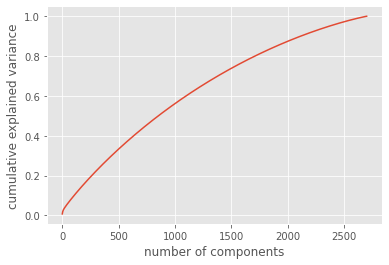

In [19]:
#Explained variance
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()